In [1]:
import pandas as pd
import numpy as np
from math import sqrt, log2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
import json
import joblib
from fancyimpute import KNN
from IPython.display import display_html
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('train_users_2.csv')
df_test = pd.read_csv('test_users.csv')

# Data Preprocessing

In [3]:
# -unknown- frequency in gender coloumn is nearly as half as much of the total number of samples.
# Removing or replacing this value with mean/media or imputing using knn will generate noise. Therefore, it's best to leave it as is.
# Handling missing values for test sets is usually problematic especially for features that are both imprtant and have large numbers of missing values.
# Therefore, I will concatenate train and test sets to fill missing values using knn and then seperate them back.
# This approach will ensure reasonable accuracy.

df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

df_train.drop(['date_first_booking'], axis=1, inplace=True)
df_test.drop(['date_first_booking'], axis=1, inplace=True)

df_train['age'] = df_train['age'].apply(lambda x: np.nan if ((x < 18) or (x > 117)) else x)
df_test['age'] = df_test['age'].apply(lambda x: np.nan if ((x < 18) or (x > 117)) else x)

# Extracting different time features from 'date_account_created' and 'timestamp_first_active'
seasons = {1: 'winter', 2:'winter', 12:'winter', 3:'spring', 4:'spring', 5:'spring', 6:'summer', 7:'summer', 8:'summer', 9:'autumn', 10:'autumn', 11:'autumn'}

# Train Set
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_train['year_ac'] = pd.DatetimeIndex(df_train['date_account_created']).year
df_train['month_ac'] = pd.DatetimeIndex(df_train['date_account_created']).month
df_train['day_ac'] = pd.DatetimeIndex(df_train['date_account_created']).day
df_train['weekday_ac'] = pd.DatetimeIndex(df_train['date_account_created']).weekday
df_train['season_ac'] = df_train['month_ac'].apply(lambda x: seasons[x])

df_train['time_first_active'] = pd.to_datetime((df_train['timestamp_first_active']), format='%Y%m%d%H%M%S')
df_train['year_fa'] = pd.DatetimeIndex(df_train['time_first_active']).year
df_train['month_fa'] = pd.DatetimeIndex(df_train['time_first_active']).month
df_train['day_fa'] = pd.DatetimeIndex(df_train['time_first_active']).day
df_train['weekday_fa'] = pd.DatetimeIndex(df_train['time_first_active']).weekday
df_train['season_fa'] = df_train['month_fa'].apply(lambda x: seasons[x])

df_train.drop(['date_account_created'], axis=1, inplace=True)
df_train.drop(['timestamp_first_active'], axis=1, inplace=True)
df_train.drop(['time_first_active'], axis=1, inplace=True)

# Test Set
df_test['date_account_created'] = pd.to_datetime(df_test['date_account_created'])
df_test['year_ac'] = pd.DatetimeIndex(df_test['date_account_created']).year
df_test['month_ac'] = pd.DatetimeIndex(df_test['date_account_created']).month
df_test['day_ac'] = pd.DatetimeIndex(df_test['date_account_created']).day
df_test['weekday_ac'] = pd.DatetimeIndex(df_test['date_account_created']).weekday
df_test['season_ac'] = df_test['month_ac'].apply(lambda x: seasons[x])

df_test['time_first_active'] = pd.to_datetime((df_test['timestamp_first_active']), format='%Y%m%d%H%M%S')
df_test['year_fa'] = pd.DatetimeIndex(df_test['time_first_active']).year
df_test['month_fa'] = pd.DatetimeIndex(df_test['time_first_active']).month
df_test['day_fa'] = pd.DatetimeIndex(df_test['time_first_active']).day
df_test['weekday_fa'] = pd.DatetimeIndex(df_test['time_first_active']).weekday
df_test['season_fa'] = df_test['month_fa'].apply(lambda x: seasons[x])

df_test.drop(['date_account_created'], axis=1, inplace=True)
df_test.drop(['timestamp_first_active'], axis=1, inplace=True)
df_test.drop(['time_first_active'], axis=1, inplace=True)


# Simple Dimensionality Reduction

In [4]:
# First, I will combine train and test sets into a temporary dataframe to fill missing values using knn.
# The temp dataframe will be seperated back into train and test sets after imputation.
# This approach reduced from 163 to 43 dimensions.

df_temp = pd.concat([df_train,df_test], keys=[0,1])

# Frequency dictionaries
frq_suf = df_temp['signup_flow'].value_counts().to_dict()
frq_lang = df_temp['language'].value_counts().to_dict()
frq_ap = df_temp['affiliate_provider'].value_counts().to_dict()
frq_fdt = df_temp['first_device_type'].value_counts().to_dict()
frq_brws = df_temp['first_browser'].value_counts().to_dict()

threshold = 37 # group values with frequency below this threshold into one feature

df_temp['signup_flow'] = df_train['signup_flow'].apply(lambda x: 'other' if frq_suf[x] < threshold else x)
df_temp['language'] = df_train['language'].apply(lambda x: 'other' if frq_lang[x] < threshold else x)
df_temp['affiliate_provider'] = df_train['affiliate_provider'].apply(lambda x: 'other' if frq_ap[x] < threshold else x)
df_temp['first_device_type'].replace(['Mac Desktop', 'Windows Desktop', 'Desktop (Other)'], 'Desktop', inplace = True)
df_temp['first_device_type'].replace(['iPhone', 'Android Phone', 'SmartPhone (Other)'], 'Smartphone', inplace = True)
df_temp['first_device_type'].replace(['iPad', 'Android Tablet'], 'Tablet', inplace = True)
df_temp['first_browser'] = df_train['first_browser'].apply(lambda x: 'other' if frq_brws[x] < threshold else x)

# Previously I extracted seasons from month_ac and month_fa to use for prediction and data visualisation.
# I realise now that this may create problems when predicting due to the fact that month and season features are highly correlated.
# Will be kept above for visualisation purposes (later).
df_temp.drop(['season_ac', 'season_fa'], axis=1, inplace=True)


# Labelling values



In [5]:
# first_affiliate_tracked coloumn has null values that need to be imputed.
# country_destination will have new null values after combining datasets.
# Non-null values of first_affiliate_tracked and country_destination will be encoded seperately and inserted back into df_temp using numpy squeeze.

categories = ['gender', 'signup_method', 'signup_flow', 'language',  'affiliate_channel', 'affiliate_provider', 'signup_app', 'first_device_type', 'first_browser']
le = LabelEncoder()
le_f = LabelEncoder()

first_affiliate_nonulls = np.array(df_temp['first_affiliate_tracked'].dropna())
first_affiliate_nonulls = first_affiliate_nonulls.reshape(-1,1)
first_affiliate_encoded = le_f.fit_transform(first_affiliate_nonulls)
df_temp['first_affiliate_tracked'].loc[df_temp['first_affiliate_tracked'].notnull()] = np.squeeze(first_affiliate_encoded)

country_dest_nonulls = np.array(df_temp['country_destination'].dropna())
country_dest_nonulls = country_dest_nonulls.reshape(-1,1)
country_dest_encoded = le.fit_transform(country_dest_nonulls)
df_temp['country_destination'].loc[df_temp['country_destination'].notnull()] = np.squeeze(country_dest_encoded)

for i in categories:
    df_temp[i] = le_f.fit_transform(df_temp[i])


# Missing Values Imputation

In [ ]:
# Imputation (This will take ~20 minutes)
# You can skip this step. I've already run it and exported the filled df to df_impute.csv (included in main directory)

def get_k(n, chunks=10):
    k = round(sqrt(n/chunks))
    if k % 2 == 0:
        return k-1
    else:
        return k
        
chunks = 10
k = get_k(n=df_temp.shape[0], chunks=chunks)
df_temp_2 = df_temp.copy()
df_temp_2.drop(['country_destination'], axis=1, inplace=True)
cols = list(df_temp_2.columns)
df_impute = pd.DataFrame()

for chunk in np.array_split(df_temp_2, chunks):
    chunk = np.round(KNN(k=k).fit_transform(chunk))
    df_chunk = pd.DataFrame(data=chunk, columns=cols)
    df_impute = pd.concat([df_impute, df_chunk], axis=0, ignore_index=True)

df_impute.to_csv('df_impute.csv')

In [6]:
# Run this cell if you skipped the previous one.
df_impute = pd.read_csv('df_impute.csv')

In [7]:
# Filling and splitting

age_imputed = df_impute['age'].to_numpy()
fa_imputed = df_impute['first_affiliate_tracked'].to_numpy()

df_temp['age'] = age_imputed
df_temp['first_affiliate_tracked'] = fa_imputed

df_target = df_temp.xs(0)['country_destination']
target = df_target.values

df_temp.drop(['country_destination'], axis=1, inplace=True)


# Encoding Values

In [8]:
categories = ['gender', 'signup_method', 'signup_flow', 'language',  'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
ct = ColumnTransformer([('encoder', OneHotEncoder(), categories)], remainder='passthrough')
matrix = ct.fit_transform(df_temp)
df = pd.DataFrame(matrix)

train = df[:len(df_train)].values
test = df[len(df_train):].values
df_target = df_target.astype(int)
target = df_target.values


# Modelling

In [9]:
# This is a multi-class classification problem. The prediction output for each row is the top 5 country destinations
# with highest probability. Using sklearn accuracy metric won't give real accuracy.
# NDCG (Normalized Discounted Cumulative Gain) is the evaluation metric used for this competition.

def acc_ndcg(y_test, y_pred_proba):
    acc = []
    for i in range(len(y_pred_proba)):
        p = np.argsort(y_pred_proba[i])[-5:][::-1]
        t = y_test[i]
        try:
            index = int(np.where(p == t)[0][0]+1)
            dcg = 1/(log2(index + 1))
        except:
            dcg = 0.0
        acc.append(dcg)
    return np.mean(acc)


def clf_name(clf):
    return clf.__class__.__name__


In [ ]:
# You can skip this cell. I've already trained and exported all the models.
# Extensive grid search has been done to tune the parameters. Details in the file named: 'predict_extended.ipynb'
# I've commented the section for SVC because it takes hours to fit. Comment out if you want to run it.
# The models can be downloaded from here: https://drive.google.com/drive/folders/1CAMD8mVNjHKWsLxO5LIpswukDK_Vxtvy?usp=sharing

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=28, shuffle=True)

pd.DataFrame(X_train).to_csv('X_train.csv')
pd.DataFrame(X_test).to_csv('X_test.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

classifiers = []

clf_cb = CatBoostClassifier(loss_function='MultiClass', task_type='GPU', max_depth=11, iterations=1000, learning_rate=0.01, random_state=28)
classifiers.append(clf_cb)

clf_xgb = XGBClassifier(max_depth=5, learning_rate=0.3, n_estimators=25, objective='multi:softprob', colsample_bytree=0.6, seed=28)
classifiers.append(clf_xgb)

clf_dtree = DecisionTreeClassifier(max_depth=4)
classifiers.append(clf_dtree)

clf_rndforest = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=11, min_samples_split=50, min_samples_leaf=50)
classifiers.append(clf_rndforest)

clf_knn = KNeighborsClassifier(n_neighbors=475, weights='distance')
classifiers.append(clf_knn)

for clf in classifiers:
    clf.fit(X_train, y_train)
    if clf_name(clf) == 'CatBoostClassifier':
        clf.save_model(clf_name(clf)+'.json', format='json')
    elif clf_name(clf) == 'XGBClassifier':
        clf.save_model(clf_name(clf)+'.json')
    else:
        joblib.dump(clf, str(clf_name(clf)+'.joblib')
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    acc = acc_ndcg(y_test, y_pred_proba)
    print('Accuracy of %s: %s'%(clf_name(clf), acc))

#clf_svm = SVC(decision_function_shape='ovo', probability=True, random_state=28) # Problem with name (RandomForrestClassifier) + Takes hours because one-vs-one
#clf_svm.fit(X_train, y_train)
#joblib.dump(clf_svm, 'SVM.joblib')
#y_pred = clf_svm.predict(X_test)
#y_pred_proba = clf_svm.predict_proba(X_test)
#acc = acc_ndcg(y_test, y_pred_proba)
#print('Accuracy of SVM: %s'%(acc)) 


In [28]:
# Run this cell if you skipped the previous one.
# X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=28, shuffle=True)

X_train = pd.read_csv('X_train.csv')
X_train.drop(X_train.columns[0], axis=1, inplace=True)
X_train = X_train.values

X_test = pd.read_csv('X_test.csv')
X_test.drop(X_test.columns[0], axis=1, inplace=True)
X_test = X_test.values

y_train = pd.read_csv('y_train.csv')
y_train.drop(y_train.columns[0], axis=1, inplace=True)
y_train = y_train.values

y_test = pd.read_csv('y_test.csv')
y_test.drop(y_test.columns[0], axis=1, inplace=True)
y_test = y_test.values


clf_cb = CatBoostClassifier()
clf_cb.load_model(clf_name(clf_cb)+'.json', 'json')
y_pred_cb = clf_cb.predict(X_test)
y_pred_proba_cb = clf_cb.predict_proba(X_test)
print('Accuracy of %s: %s'%(clf_name(clf_cb), acc_ndcg(y_test, y_pred_proba_cb)))

clf_xgb = XGBClassifier()
clf_xgb.load_model(clf_name(clf_xgb)+'.json')
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)
print('Accuracy of %s: %s'%(clf_name(clf_xgb), acc_ndcg(y_test, y_pred_proba_xgb)))

clf_dtree = DecisionTreeClassifier()
clf_dtree = joblib.load(clf_name(clf_dtree)+'.joblib')
y_pred_dtree = clf_dtree.predict(X_test)
y_pred_proba_dtree = clf_dtree.predict_proba(X_test)
print('Accuracy of %s: %s'%(clf_name(clf_dtree), acc_ndcg(y_test, y_pred_proba_dtree)))

clf_rndforest = RandomForestClassifier()
clf_rndforest = joblib.load(clf_name(clf_rndforest)+'.joblib')
y_pred_rndforest = clf_rndforest.predict(X_test)
y_pred_proba_rndforest = clf_rndforest.predict_proba(X_test)
print('Accuracy of %s: %s'%(clf_name(clf_rndforest), acc_ndcg(y_test, y_pred_proba_rndforest)))

clf_knn = KNeighborsClassifier()
clf_knn = joblib.load(clf_name(clf_knn)+'.joblib')
y_pred_knn = clf_knn.predict(X_test)
y_pred_proba_knn = clf_knn.predict_proba(X_test)
print('Accuracy of %s: %s'%(clf_name(clf_knn), acc_ndcg(y_test, y_pred_proba_knn)))

clf_svm = SVC()
clf_svm = joblib.load('SVM.joblib')
y_pred_svm = clf_svm.predict(X_test)
y_pred_proba_svm = clf_svm.predict_proba(X_test)
print('Accuracy of SVM: %s'%(acc_ndcg(y_test, y_pred_proba_svm)))


Accuracy of CatBoostClassifier: 0.8168109083326747
Accuracy of XGBClassifier: 0.8164678875307924
Accuracy of DecisionTreeClassifier: 0.8137073989324712
Accuracy of RandomForestClassifier: 0.8156357928545922
Accuracy of KNeighborsClassifier: 0.7834471777253587
Accuracy of SVM: 0.8151659500755046


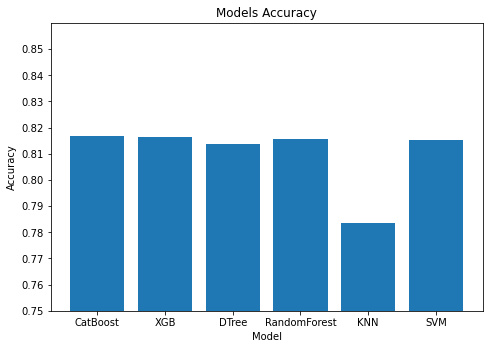

In [29]:
# Plot models vs accuracy(ndcg)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_yticks(np.arange(0.75, 0.86, 0.01))
ax.set_ylim([0.75, 0.86])
plt.title('Models Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
x = ['CatBoost', 'XGB', 'DTree', 'RandomForest', 'KNN', 'SVM']
y = [acc_ndcg(y_test, y_pred_proba_cb), acc_ndcg(y_test, y_pred_proba_xgb) , acc_ndcg(y_test, y_pred_proba_dtree), acc_ndcg(y_test, y_pred_proba_rndforest), acc_ndcg(y_test, y_pred_proba_knn), acc_ndcg(y_test, y_pred_proba_svm)]
ax.bar(x,y)
#plt.savefig('models_acc.png')
plt.show()

In [11]:
# Predicting

y_pred_proba = clf_cb.predict_proba(test)
predictions = pd.DataFrame(columns=['id', 'country_destination'])
temp = pd.read_csv('test_users.csv')
temp = temp['id'].values
idx = []
cd = []
for i in temp:
    for _ in range(5):
        idx.append(i)
idx = np.array(idx)
predictions['id'] = idx

for i in range(len(y_pred_proba)):
    pred = le.inverse_transform(np.argsort(y_pred_proba[i])[-5:][::-1])
    for p in pred:
        cd.append(p)
cd = np.array(cd)
predictions['country_destination'] = cd
predictions.to_csv('predictions.csv', index=False)

In [12]:
predictions.head()

,id,country_destination
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
